In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model as lm
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from stop_words import get_stop_words
import Stemmer
import pymorphy2
from segtok import segmenter
import re
from functools import partial
import pickle
from gensim import corpora, models
from gensim.models import word2vec
import xgboost as xgb 
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers.advanced_activations import PReLU
from keras.optimizers import SGD

Using Theano backend.


In [3]:
data = pd.read_csv('data/comments.csv.gz')

In [4]:
data.shape

(109529, 6)

In [5]:
data.is_gum.value_counts()

1.0    54803
0.0    54726
Name: is_gum, dtype: int64

In [6]:
data.head(3)

,from_id,text,is_gum,hour,likes,sex
0,56343863,Я один не вижу её в подписчиках?,0.0,21,0,2
1,4901340,"[id262927831|Семён], ей даже за бабки никто св...",0.0,8,1,2
2,4901340,"Ебаные дибилы дело блять не в растает,а темпер...",0.0,8,31,2


### Length of comments (symbols)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109529 entries, 0 to 109528
Data columns (total 6 columns):
from_id    109529 non-null int64
text       109529 non-null object
is_gum     109529 non-null float64
hour       109529 non-null int64
likes      109529 non-null int64
sex        109529 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 5.0+ MB


In [8]:
lenghts_symb = np.array([len(m) for m in data.text.values])

In [9]:
lenghts_symb.mean(), np.median(lenghts_symb)

(78.884624163463556, 47.0)

In [10]:
min(lenghts_symb), max(lenghts_symb)

(1, 7420)

In [11]:
sum(lenghts_symb)

8640154

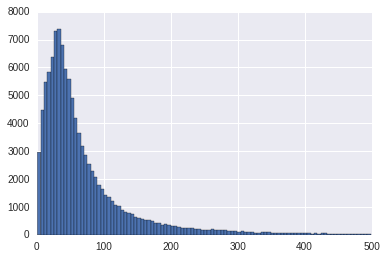

In [12]:
plt.hist(lenghts_symb[lenghts_symb < 500], bins=100);

In [13]:
print('{:.2f}% of comments are shorter than {} symbols'
      .format(lenghts_symb[lenghts_symb < 500].shape[0] / lenghts_symb.shape[0] * 100, 500))

98.86% of comments are shorter than 500 symbols


In [14]:
print('{:.2f}% of comments are longer than {} symbols'
      .format(lenghts_symb[lenghts_symb > 20].shape[0] / lenghts_symb.shape[0] * 100, 15))

82.89% of comments are longer than 15 symbols


### Length of comments (words)

In [15]:
lenghts_word = np.array([len(m.split()) for m in data.text.values])

In [16]:
lenghts_word.mean(), np.median(lenghts_word)

(11.824347889600014, 7.0)

In [17]:
min(lenghts_word), max(lenghts_word)

(0, 1143)

In [18]:
sum(lenghts_word)

1295109

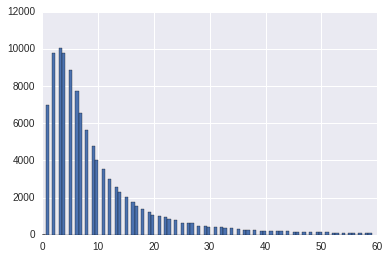

In [19]:
plt.hist(lenghts_word[lenghts_word < 60], bins=100);

In [20]:
print('{:.2f}% of comments are shorter than {} words'
      .format(lenghts_word[lenghts_word < 60].shape[0] / lenghts_word.shape[0] * 100, 60))

97.91% of comments are shorter than 60 words


In [21]:
print('{:.2f}% of comments are longer than {} words'
      .format(lenghts_word[lenghts_word > 4].shape[0] / lenghts_word.shape[0] * 100, 4))

66.63% of comments are longer than 4 words


### Links

In [22]:
links = [m for m in data.text.values if 'http' in m or 'www' in m or '.ru' in m or '.com' in m] 

In [23]:
links[:5]

['http://vk.com/feed?w=wall153043142_4008',
 'http://vk.com/photo4028388_337391386',
 '[id102017653|Иван], http://www.pdd24.com/',
 '[id146312098|Юля], https://www.google.com/search?q=%D0%BD%D0%BE%D1%87%D0%BD%D0%BE%D0%B9+%D0%B5%D0%BA%D0%B0%D1%82%D0%B5%D1%80%D0%B8%D0%BD%D0%B1%D1%83%D1%80%D0%B3&newwindow=1&biw=1920&bih=971&source=lnms&tbm=isch&sa=X&ei=zM4_VOHIAab8ywOB44CACg&ved=0CAYQ_AUoAQ',
 '[id146312098|Юля], http://vk.com/album-32182751_151375905']

In [24]:
print('{:.2f}% of comments contain links'.format(len(links) / len(data) * 100))

0.58% of comments contain links


## Preprocessing

### Dropping short and long

In [25]:
comments = data[(lenghts_word < 60) & (lenghts_word > 4)]

In [26]:
comments.shape

(70693, 6)

### Dropping with spam

In [27]:
without_link = [False if 'http' in c or 'www' in c or '.ru' in c or '.com' in c else True for c in comments.text.values] 

In [28]:
comments = comments[without_link]

In [29]:
comments.shape

(70322, 6)

In [30]:
comments_lenghts = np.array([len(m) for m in comments.text.values])

In [31]:
comments_lenghts.argsort()[:10]

array([21846, 54384,  8177, 44397,  8558, 58265,  4787, 15466, 60497, 25625])

In [32]:
comments.text.values[21846]

'Н И К А К'

In [33]:
comments.is_gum.value_counts()

1.0    35481
0.0    34841
Name: is_gum, dtype: int64

In [34]:
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 3), analyzer='word', min_df=50)
X = vectorizer.fit_transform(comments.text.values)
y = comments.is_gum.values

In [35]:
X.shape

(70322, 1000)

In [36]:
lr = lm.LogisticRegression()

In [ ]:
np.random.seed(0)

In [37]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.52546837337777197, 0.0052943301934649046)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(char_features.toarray(), comments.is_gum, test_size=0.2, random_state=0)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(vects, comments.is_gum, test_size=0.2, random_state=0)

In [183]:
X_train.shape, y_train.shape

((55979, 500), (55979,))

In [184]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.54019292604501612

In [104]:
vectorizer.get_feature_names()[1565]

'5|p'

In [119]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 2000, 50)]

array(['040', '-не', '797', '447', '156', '0|с', '851', '582', '2|ю',
       '866', ' ны', '894', '926', '.а ', '351', '66|', '.в ', '600',
       ' пф', '05|', '682', '-во', ' 90', ' ди', '770', '168', '824',
       ',ра', '164', ' 4 ', '108', '?) ', ' ак', '262', '0|и', '853',
       '965', '632', ' яв', '169', ' ??', '433', '0|и', '124', '018',
       '406', '204', ' шк', '518', 'd26'], 
      dtype='<U3')

### NN

In [185]:
model = Sequential()
model.add(Dense(300, input_shape=(500,)))
model.add(Activation(PReLU()))
model.add(Dropout(0.4))
model.add(Dense(20, activation='tanh'))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [186]:
%%time
history = model.fit(X_train, y_train,
                    nb_epoch=10, batch_size=1024,
                    verbose=1, validation_split=0.1)

Train on 50381 samples, validate on 5598 samples
Epoch 1/10
50381/50381 [==============================] - 4s - loss: 0.6924 - acc: 0.5160 - val_loss: 0.6900 - val_acc: 0.5463
Epoch 2/10
50381/50381 [==============================] - 3s - loss: 0.6892 - acc: 0.5370 - val_loss: 0.6879 - val_acc: 0.5448
Epoch 3/10
50381/50381 [==============================] - 4s - loss: 0.6864 - acc: 0.5483 - val_loss: 0.6873 - val_acc: 0.5513
Epoch 4/10
50381/50381 [==============================] - 4s - loss: 0.6835 - acc: 0.5546 - val_loss: 0.6880 - val_acc: 0.5402
Epoch 5/10
50381/50381 [==============================] - 4s - loss: 0.6805 - acc: 0.5645 - val_loss: 0.6901 - val_acc: 0.5484
Epoch 6/10
50381/50381 [==============================] - 4s - loss: 0.6777 - acc: 0.5716 - val_loss: 0.6896 - val_acc: 0.5459
Epoch 7/10
50381/50381 [==============================] - 4s - loss: 0.6745 - acc: 0.5770 - val_loss: 0.6893 - val_acc: 0.5486
Epoch 8/10
50381/50381 [==============================] - 4s -

In [78]:
score = model.evaluate(X_test.toarray(), y_test,
                       batch_size=512, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

22453/22453 [==============================] - 1s     
Test score: 0.605155182597
Test accuracy: 0.690241838308


### XGB

In [187]:
params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_matrics': 'error',
}

In [188]:
%%time
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

gbm = xgb.train(params, dtrain, 1000, watchlist, verbose_eval=True, early_stopping_rounds=50)

Will train until eval error hasn't decreased in 50 rounds.
[0]	train-error:0.456850	eval-error:0.484459
[1]	train-error:0.438575	eval-error:0.487245
[2]	train-error:0.425677	eval-error:0.482387
[3]	train-error:0.413584	eval-error:0.482744
[4]	train-error:0.404813	eval-error:0.483744
[5]	train-error:0.396506	eval-error:0.485173
[6]	train-error:0.392415	eval-error:0.481743
[7]	train-error:0.385180	eval-error:0.481100
[8]	train-error:0.380285	eval-error:0.479957
[9]	train-error:0.378088	eval-error:0.481458
[10]	train-error:0.370657	eval-error:0.477814
[11]	train-error:0.368853	eval-error:0.476670
[12]	train-error:0.361511	eval-error:0.476527
[13]	train-error:0.357616	eval-error:0.476384
[14]	train-error:0.352561	eval-error:0.471668
[15]	train-error:0.348756	eval-error:0.473526
[16]	train-error:0.344754	eval-error:0.475456
[17]	train-error:0.340217	eval-error:0.476242
[18]	train-error:0.336894	eval-error:0.475027
[19]	train-error:0.333446	eval-error:0.475956
[20]	train-error:0.331732	eval-

CPU times: user 12min 34s, sys: 736 ms, total: 12min 35s
Wall time: 3min 19s


[113]	train-error:0.169903	eval-error:0.470311
Stopping. Best iteration:
[63]	train-error:0.239143	eval-error:0.468739



In [151]:
sorted(gbm.get_fscore().items(), key=lambda x: -x[1])[:5]

[('f127', 57), ('f155', 53), ('f154', 51), ('f2547', 47), ('f1737', 45)]

In [156]:
list(filter(lambda x: x[1] == 1737, vectorizer.vocabulary_.items()))

[('но ', 1737)]

In [211]:
comment_features.columns[3]

'punct_)'

In [133]:
pred = gbm.predict(dvalid)

In [134]:
pred

array([ 0.46096328,  0.55611199,  0.51957262, ...,  0.45535901,
        0.61733341,  0.53305769], dtype=float32)

In [135]:
accuracy_score(y_test, pred > 0.5)

0.5349053233297606

## Testing meta features

In [62]:
is_man = np.reshape((comments.sex == 2).astype('int'), (-1, 1))

In [63]:
is_with_like = np.reshape((comments.likes > 0).astype('int'), (-1, 1))

In [64]:
X = pd.get_dummies(comments.hour, prefix='h').values
X = np.hstack((X, is_with_like, is_man))

In [65]:
def get_meta_features():
    features = pd.DataFrame()
    features['is_man'] = comments.sex == 2
    features['is_with_like'] = comments.likes > 0
    features = pd.concat((features, pd.get_dummies(comments.hour, prefix='h')), axis=1)
    return features

In [66]:
meta_features = get_meta_features()

In [67]:
meta_features.head()

,is_man,is_with_like,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
1,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
baseline_scores = cross_val_score(lr, meta_features, comments.is_gum, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.68691930589059214, 0.054023485908062177)

## Emoji

In [38]:
comments_list = comments.text.values

In [39]:
with open('emoji.txt', 'r') as f:
    lines = f.readlines()
emojis = [line[0] for line in lines]

In [40]:
def is_with_emoji(comment):
    for em in emojis:
        if em in comment:
            return 1
    return 0

In [41]:
def with_emoji(comments):
    return [is_with_emoji(c) for c in comments]

In [42]:
def get_emoji(comment, repetition=True):
    ems = []
    for em in emojis:
        if not repetition:
            if em in comment:
                ems.append(em)
        else:
            founded = re.findall(em, comment)
            if len(founded) > 0:
                ems.extend(founded)
    return ems

In [43]:
get_emoji(' 🔥 🔥 👏')

['👏', '🔥', '🔥']

In [44]:
get_emoji(' 🔥 🔥 👏', False)

['👏', '🔥']

#### If not done before

In [45]:
%time emoji_from_comments_rep = list(map(get_emoji, comments_list))

CPU times: user 30min 20s, sys: 176 ms, total: 30min 20s
Wall time: 31min 37s


In [46]:
with open('emoji_from_comments_rep_ekb.pkl', 'wb') as f:
    pickle.dump(emoji_from_comments_rep, f)

#### Else load

In [47]:
with open('emoji_from_comments_rep_ekb.pkl', 'rb') as f:
    emoji_from_comments_rep = pickle.load(f)

In [48]:
emoji_from_comments_no_rep = list(map(lambda com: get_emoji(com, False), comments_list))

In [49]:
def get_emoji_proportion(comments, emoji_from_coms=None, repetition=True):
    emoji_proportion = [] 
    func = lambda com: get_emoji(com, repetition)
    if not emoji_from_coms:
        emoji_from_coms = list(map(func, comments))
    
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        emoji_proportion.append(len(emoji_from_coms[i]) / len(com))
    return np.array(emoji_proportion)

In [50]:
get_emoji_proportion(['🔥 🔥 🔥 👏 😊'])

array([ 1.])

In [51]:
get_emoji_proportion(['🔥 🔥 🔥 👏 😊'], repetition=False)

array([ 0.6])

In [52]:
em_proportion_rep = get_emoji_proportion(comments_list, emoji_from_comments_rep)

In [53]:
em_proportion_no_rep = get_emoji_proportion(comments_list, emoji_from_comments_no_rep)

### With repetition

In [54]:
(em_proportion_rep > 0.25).sum()

18

In [55]:
comments_list[em_proportion_rep > 0.25][:20]

array(['🐈 🐈 🐈 🐈 🐈 🐈', 'го CS 1.6 👍 👍 👍',
       'Скоро, уже совсем скоро! 👙👓🐠🐟☀☀☀🏊⛵✈', '-тся  и - ться! 😁😩😖🔫',
       '😆 😆 😆 😆 капееец', 'даааааааааааааааааа 💜 💛 💚 💝 💞 💗 💙',
       '😭 😭 😭 😭 я в тебя верю',
       '😎 😎 😎 😎 😎 ❤ ❤ ❤ ❤ ❤ ❤ ❤ ❤ ❤ ❤ ❤ ❤ романтикаааааааааааааааа',
       '😆 😆 😆 😆 😆 😆 😆 😆 😆 😆', '😂 😂 😂 😂 😂 😂 😂',
       'Доброе утро, страна!!! 😊 🍐 🍏 🍓 🍋 🍍 🍒', 'Милота!  😜  😆  😆  😆',
       '15м2 одна яма ????? 😱 😱 😱 😱 😱 😱', '😊 😊 😊 😊 Смешно!', '😢 😭 😭 😭 😭',
       'фотка - супер 👍  👍  👍  👍', 'е мае 😃 😃 😃', 'Красотища) 🍁 🍂 🌳 🌲'], dtype=object)

### Without repetition

In [56]:
(em_proportion_no_rep > 0.1).sum()

39

In [57]:
comments_list[em_proportion_rep > 0.1][:20]

array(['😂😂😂😂😂ужас ну это уже внукам', 'Make love, not war👫👌👈 👍🔞',
       'Только не у меня, 4-вых. 5- раб, 6-вых, ху.,я какая то 👿👿👿👿👿👿👿👿👿👿👿👿👿👿',
       'ни разу такого не было ☝ ☝ ☝ 😃 😂', 'Вот это любовь 😃 😂 😂 😂',
       'киберсиси...а чё...прикольно☺ киберсиси😁 кибер, мать его, сиси 😂😂😂👍👍👍',
       '[id32993755|Ксения], 😆😆😆😆😆😆 какой милый максимализм👍',
       '[id178809329|Дарія], 😆  😆  😆  😆', '🐈 🐈 🐈 🐈 🐈 🐈', 'го CS 1.6 👍 👍 👍',
       'Ааа " Гроза домашних животных".... 😂😂😂😂',
       '[id234931816|Marat], 🔞 🔞 🔞 🔞 🔞',
       'Приветы, удачно погудеть этой ночью!!!🙏😄😄😄',
       '[id174813903|Виктория], > просто это ВК а не дипломная работа😉\nРоссия встанет с колен, когда такие, как Вы, передохнут \n😉😉😉😉😉😉😉😉😉😉😉😉😉😉😉😉😉😉😉😉😉😉😉',
       'Пяяятница привет!! Доброе утро всем!!👍👍👍☺',
       'С Новым Годом, Екатеринбург. 🎁 Привет из Севастополя! ❄ 🍊 🍷 🍸 ✌ 🇷🇺',
       'А я завтра улетаю 💃💃💃в лето! ☀☀☀', 'А потом я вас разыграю 😂😂😂',
       'Скоро, уже совсем скоро! 👙👓🐠🐟☀☀☀🏊⛵✈',
       'С днем пог

### Proportion of alphabetical symbols

In [58]:
def get_abc_proportion(comments):
    abc_proportion = []     
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        abc = re.findall('[а-яёa-z]', com, flags=re.IGNORECASE)
        abc_proportion.append(len(abc) / len(com))
    return np.array(abc_proportion)

In [59]:
abc_proportion = get_abc_proportion(comments_list)

In [60]:
abc_proportion[:10]

array([ 0.96153846,  0.75      ,  0.95774648,  0.77192982,  0.6744186 ,
        0.68627451,  0.76666667,  0.88288288,  0.90909091,  0.9787234 ])

In [61]:
sum(abc_proportion < 0.4)

48

In [62]:
comments_list[abc_proportion < 0.4][:20]

array(['У меня встал в 7..................', '1 или 3 ? =))',
       '[id178809329|Дарія], 😆  😆  😆  😆', '🐈 🐈 🐈 🐈 🐈 🐈',
       '[id153783519|Денис], CS 1.6 ? 😃 😆',
       '[id234931816|Marat], 🔞 🔞 🔞 🔞 🔞', 'П ы л ь ц а...............',
       '[id757577|Андрей], 😂 😂 😂 👍',
       '[id50666528|Павел], USB 1.0, 2.0 и 3.0', '4 8 15 16 23 42',
       'Не к 2018, а к 2118.', 'С Праздником!!!!!!!!!!!!!!!!!!! 🇷🇺 🇷🇺 🇷🇺',
       '8-912-903-64-95 в 6 жду звонка)))', '[id17574944|Влад], 😊 ☺ ☺ ☺',
       '[id17574944|Влад], 😊 ☺ ☺ 👅 😆',
       '[id52522328|Саша], 😦 😮 😮 😮 зачем!?',
       'цена какая за 1кг ?????????????????????????????????',
       '[id271976133|Влад], 😆 😆 👍 👍 👍', '[id222997111|Денис], ✌ ✌ ✌ ✌',
       '[id208959482|Алёна], 😎 😎 ✌ ✌'], dtype=object)

### Filling DataFrame

In [63]:
comments['emojis'] = [' '.join(e) for e in emoji_from_comments_rep]

In [64]:
comments['em_proportion_rep'] = em_proportion_rep

In [65]:
comments['em_proportion_no_rep'] = em_proportion_no_rep

In [66]:
comments['abc_proportion'] = abc_proportion

In [67]:
comments.head(5)

,from_id,text,is_gum,hour,likes,sex,emojis,em_proportion_rep,em_proportion_no_rep,abc_proportion
0,56343863,Я один не вижу её в подписчиках?,0.0,21,0,2,,0.0,0.0,0.961538
1,4901340,"[id262927831|Семён], ей даже за бабки никто св...",0.0,8,1,2,,0.0,0.0,0.750000
2,4901340,"Ебаные дибилы дело блять не в растает,а темпер...",0.0,8,31,2,,0.0,0.0,0.957746
3,4901340,"[id4071604|Марина], да не гребу,я чисто кто в ...",0.0,8,0,2,,0.0,0.0,0.771930
5,4901340,"[id131746820|Оля], я выше написал,что не обобщил",0.0,9,0,2,,0.0,0.0,0.674419


#### If message repeats more than one time - drop (spam)

In [68]:
print('{} different spam comments'.format((comments.text.value_counts() > 1).sum()))

112 different spam comments


In [69]:
print('{} total count of spam comments'
      .format(comments.text.value_counts()[comments.text.value_counts() > 1].values.sum()))

287 total count of spam comments


### Dropping outlier

In [70]:
spam_comments = comments.text.value_counts()[comments.text.value_counts() > 1].keys()

In [71]:
comments = comments[comments.text.apply(lambda t: t not in spam_comments)]

In [72]:
index_to_del = comments[(comments.em_proportion_rep > 0.25) | (comments.abc_proportion < 0.4) | 
                        (comments.text.value_counts() != 1)].index

In [73]:
index_to_del.shape

(61,)

In [74]:
comments.drop(index_to_del, inplace=True)

In [75]:
comments.shape

(69974, 10)

In [76]:
comments_list = comments.text.values

### Replacing id

In [77]:
comments_list = []
for comment in comments.text.values:
    c = comment.split()
    if c[0].startswith('[id'):
        c[0] = 'adddresssation'
    c_ = []
    for w in c:
        if w.startswith('id'):
            c_.append('adddresssation')
        else:
            c_.append(w)
    comments_list.append(' '.join(c))
comments_list = np.array(comments_list)

In [78]:
comments_list[:5]

array(['Я один не вижу её в подписчиках?',
       'adddresssation ей даже за бабки никто свой член не даст',
       'Ебаные дибилы дело блять не в растает,а температуре и свойстве резины,плюс наледи,бараны ебаные,ладно телки в этом деле тупорогие,но за парней обидно,что они ебланы',
       'adddresssation да не гребу,я чисто кто в этой теме,не обобщаю',
       'adddresssation я выше написал,что не обобщил'], 
      dtype='<U465')

In [79]:
comments_lenghts = np.array([len(m) for m in comments_list])

## Clearing comments

In [80]:
y = comments.is_gum.values

In [81]:
adj_proportion = []

In [82]:
errors = []

In [83]:
def clear_comments(comments, with_stemmer=False, with_lemmer=False, to_lower=True, without_names=False,
                without_stop_words=False, min_word_len=None, with_emoji=False):
    global adj_proportion
    global errors 
    adj_proportion = []
    errors = []
    clear_comments = []
    stop_words = set(get_stop_words('ru'))
    stemmer = Stemmer.Stemmer('russian')
    lemmer = pymorphy2.MorphAnalyzer()
    
    names_del = 0
    i = -1
    for comment in comments:
        comment_ = comment
        i += 1
        if to_lower:
            comment = comment.lower()
        comment = re.sub('[^а-яА-ЯёЁa-zA-Z\-]', ' ', comment)
        comment = comment.split()
        if without_stop_words:
            comment = [c for c in comment if c not in stop_words]
        if with_stemmer:
            comment = stemmer.stemWords(comment)
            if without_names:
                with open('names_from_sent.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                before = len(comment)
                comment = [c for c in comment if c not in names]
                aft = len(comment)
                names_del += before - aft
        elif with_lemmer:
            parsed = [lemmer.parse(c)[0] for c in comment]
            comment = [p.normal_form for p in parsed]
            adj = sum([1 for p in parsed if 'ADJ' in str(p.tag)])
            if len(comment) == 0:
                errors.append(comment_)
                adj_proportion.append(0)
            else:
                adj_proportion.append(adj / len(comment))
            if without_names:
                with open('names.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                    before = len(comment)
                    comment = [c for c in comment if c not in names]
                    aft = len(comment)
                    names_del += before - aft
        if min_word_len is not None:
            comment = [c for c in comment if len(c) >= min_word_len]
        if with_emoji:
            comment.extend(emoji_from_comments_rep[i])
        clear_comments.append(' '.join(comment))
    print('names del: {}'.format(names_del))
    return clear_comments

### Char

In [137]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=2, with_emoji=False, with_stemmer=False,
                            with_lemmer=False, without_names=True, without_stop_words=False)

names del: 0
CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.25 s


In [138]:
clear_coms[10:15]

['adddresssation ты про чайковского',
 'adddresssation это от областников поганых не проехать утра со всех трасс такой поток съезжается ездили бы только местные было бы очень свободно',
 'куда не копни все охуено',
 'ничего не изменилось очень слабая урбанизация',
 'что она после олимпиады выйграла за года']

In [139]:
%%time
vectorizer = CountVectorizer(max_features=3000, min_df=50, ngram_range=(3, 3), analyzer='char_wb')
char_features = vectorizer.fit_transform(clear_coms)

CPU times: user 4.92 s, sys: 20 ms, total: 4.94 s
Wall time: 4.94 s


In [120]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 50)]

array(['езт', 'ай ', ' ге', 'зык', 'жде', 'выр', 'азн', ' сч', 'емя',
       'дик', 'бще', ' 😃 ', 'кил', 'еше', ' ам', ' фу', 'ема', ' мя',
       'имо', 'ежи', 'ави', 'бст', 'баб', 'гор', 'зык', 'дру', 'ion',
       'гот', 'зап', 'изв', 'жно', 'вер', ' уб', 'арш', 'гад', ' не',
       'еня', ' лю', ' пл', 'ате', 'арь', 'ера', 'зап', 'ети', 'вит',
       'вое', 'анд', ' ср', 'кал', 'бен'], 
      dtype='<U3')

### Word

In [168]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=3, with_emoji=True, with_stemmer=False,
                            with_lemmer=True, without_names=True, without_stop_words=False)

names del: 4794
CPU times: user 13min 10s, sys: 10.3 s, total: 13min 20s
Wall time: 14min 16s


In [89]:
errors

[]

In [90]:
clear_coms[10:15]

['adddresssation про чайковский',
 'adddresssation это областник поганый проехать утро весь трасса такой поток съезжаться ездить только местный быть очень свободно',
 'куда копнить весь охуить',
 'ничто измениться очень слабый урбанизация',
 'что она после олимпиада выйграло год']

In [91]:
adj_proportion[10:15]

[0.25, 0.17391304347826086, 0.2, 0.16666666666666666, 0.0]

In [136]:
%%time
vectorizer = CountVectorizer(max_features=3000, min_df=50, ngram_range=(1, 3), analyzer='word')
word_features = vectorizer.fit_transform(clear_coms)

CPU times: user 9.01 s, sys: 52 ms, total: 9.06 s
Wall time: 9.06 s


In [122]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 20)]

array(['для это', 'жизнь', 'adddresssation чем', 'давно уже', 'быть очень',
       'интересный', 'лёд', 'мег', 'adddresssation такой', 'комп',
       'весь хорошо', 'лечь', 'водитель', 'вода', 'выше',
       'adddresssation никто', 'месяц', 'вставать', 'брать', 'зайти'], 
      dtype='<U25')

In [94]:
char_features.shape, word_features.shape

((69974, 1000), (69974, 1000))

In [79]:
from sklearn import naive_bayes, neighbors, ensemble

In [78]:
lr = naive_bayes.MultinomialNB()

In [180]:
lr = ensemble.RandomForestClassifier(10, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [266]:
lr = ensemble.GradientBoostingClassifier()

In [89]:
lr = lm.LogisticRegression()

In [124]:
np.random.seed(0)

In [76]:
%%time
baseline_scores = cross_val_score(lr, word_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.516760322702 0.0102954889703
CPU times: user 5.72 s, sys: 4 ms, total: 5.72 s
Wall time: 5.72 s


In [77]:
%%time
baseline_scores = cross_val_score(lr, char_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.529098666097 0.00914137273099
CPU times: user 37.9 s, sys: 156 ms, total: 38 s
Wall time: 38 s


In [101]:
from scipy import sparse

In [102]:
word_char_features = sparse.hstack((word_features, char_features))

In [103]:
word_char_features.shape

(111920, 2000)

In [81]:
%%time
baseline_scores = cross_val_score(lr, word_char_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.528697488912 0.00809228277877
CPU times: user 45.8 s, sys: 172 ms, total: 45.9 s
Wall time: 45.9 s


In [81]:
%%time
lr.fit(X, y)

CPU times: user 8min 12s, sys: 144 ms, total: 8min 12s
Wall time: 2min 5s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [82]:
lr.score(X, y)

0.67386973776359815

In [83]:
lr.feature_importances_.argsort()[-10:]

array([648, 765, 206, 499, 182, 183, 106, 214, 306, 870])

In [408]:
lr.coef_.argmax()

462

In [84]:
vectorizer.get_feature_names()[648]

'прав'

In [85]:
for w in lr.feature_importances_.argsort()[-100:]:
    print(vectorizer.get_feature_names()[w])

куп
ваш
кажд
хочет
разн
сильн
групп
ответ
реальн
голов
равн
тво
собак
поэт
езд
красив
хотел
рук
вод
сраз
нужн
чита
еха
дет
главн
суд
автор
личн
никак
жизн
нет
больш
ноч
сторон
народ
писа
район
добр
врод
интересн
кстат
счита
утр
деньг
блин
перв
наверн
улиц
смотр
мог
муж
вопрос
плох
точн
поня
понима
час
прям
город
мест
девушк
работ
работа
знает
наш
жив
дава
водител
случа
фот
вид
пуст
видел
пост
ход
скор
сам
написа
зна
стран
человек
друг
что
нормальн
хорош
слов
говор
сто
сво
дорог
прав
сдела
дом
одн
дел
дела
вообщ
дума
как
так


### Is the first letter of sentence upper

In [148]:
def sentence_stat(comments):
    big_letter = []
    sents_count = []
    for comment in comments:
        sents = list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', comment)))
        count = sum([1 for sent in sents if sent and (sent[0].isupper() or 'adddresssation' in sent
                                                      or (len(sent) > 1 and sent[0] == '"' and sent[1].isupper()))])
        total = sum([1 for sent in sents if sent.strip() != ''
                     and re.match('.*[a-zа-яё].*', sent.strip(), flags=re.IGNORECASE)])
        # print(count, total)
        if total:
            big_letter.append(count // total)
        else:
            big_letter.append(1)
        sents_count.append(total)
    return big_letter, sents_count

In [314]:
print(re.match('.*[a-zа-яё].*', '', flags=re.IGNORECASE))

None


In [43]:
sentence_stat(comments_list[250:260])

([1, 0, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 3, 3, 1, 2, 1, 1, 3, 3])

In [282]:
comments_list[355:360]

['adddresssation 😂😂😂да мне больше про смерть узнать как они умрууут😂😂😂😂😂',
 'adddresssation вот и я об этом умрут все..а до смерти ещн далековато...поэтому пусть все все все что хотят то и творят...жизнь дается однажды...надо быть собой...а не скрывать свои желания..ссылаясь на стереотипы..',
 'adddresssation если эти вопросы все мне то я б ответила просто я не курю...Просто не люблб когда осуждают людей..ну курят и курят ну выпивают иногда и что теперь..? Каждый должен делать то что ему по душе...',
 'adddresssation на работе 😂😂😂',
 'Отличноооо все...И погода оболден👍👍👍👍ная']

In [323]:
[list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', c))) for c in comments_list[350:360]]

[['Первый выпал еще вчера', '😂😂😂😂'],
 ['adddresssation это до матча было?'],
 ['😓😓😓😓😓блиииин жалькооо мне что делать', '?блиииин а как помочь'],
 ['Чет я не врублюсь в чем смысл ??😂😂😂😂'],
 ['adddresssation 😂😂😂😂😂😂😂какой тупизм',
  'а что тогда происходит с не курящими?'],
 ['adddresssation 😂😂😂да мне больше про смерть узнать как они умрууут😂😂😂😂😂'],
 ['adddresssation вот и я об этом умрут все',
  'а до смерти ещн далековато',
  'поэтому пусть все все все что хотят то и творят',
  'жизнь дается однажды',
  'надо быть собой',
  'а не скрывать свои желания',
  'ссылаясь на стереотипы',
  ''],
 ['adddresssation если эти вопросы все мне то я б ответила просто я не курю',
  'Просто не люблб когда осуждают людей',
  'ну курят и курят ну выпивают иногда и что теперь',
  '?',
  'Каждый должен делать то что ему по душе',
  ''],
 ['adddresssation на работе 😂😂😂'],
 ['Отличноооо все', 'И погода оболден👍👍👍👍ная']]

In [480]:
%%time
big_letter, sents_count = sentence_stat(comments_list)
big_letter = np.reshape(big_letter, (-1, 1))
sents_count = np.reshape(sents_count, (-1, 1))

CPU times: user 4.66 s, sys: 0 ns, total: 4.66 s
Wall time: 4.66 s


In [481]:
sents_count[350:360]

array([[1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [7],
       [4],
       [1],
       [2]])

In [482]:
pd.Series(big_letter.ravel()).value_counts()

1    86835
0    41675
dtype: int64

In [487]:
baseline_scores = cross_val_score(lr, sents_count, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.483230876975 0.0236564121478


In [277]:
comments['all_sent_upper'] = letters

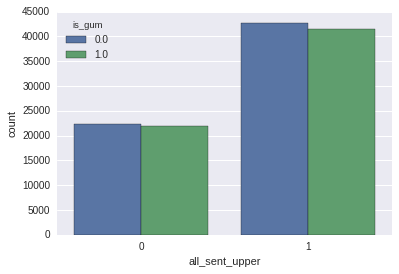

In [325]:
sns.countplot(x='all_sent_upper', hue='is_gum', data=comments)

### Punctuation count in comment

In [149]:
def punctuation_counts(comments, pattern='\(+', partion=True):
    if partion:
        return [sum(len(p) for p in re.findall(pattern, c)) / len(c) * 100 for c in comments]
    else:
        return [1 if len(re.findall(pattern, c)) > 0 else 0 for c in comments]

In [153]:
comments_list[:10]

['НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ОТПРАВИТЬ 💪💪💪💪💪',
 'adddresssation не имеет значение где ЮР, ардрес то',
 'adddresssation где СК удобнее там и проводят а поближе подороже! Могу мск то сделать 650р',
 'Сегодня в 23:00 до 5:00 собираемся все НА АРЕНЕ и Валим там пока покрышки не сгорят... В ПРОТЕСТ СКУЧНЫМ И НУДНЫМ МУДАКАМ',
 'adddresssation пошлиб да проявили смелость там😉',
 'adddresssation любое ДТП есть страховой случай! И будет оплачиваться в законном порядке... А как в тебя въехали не ИМЕЕТ ЗНАЧЕНИЯ!',
 'adddresssation что если кого то что то неустраевает пойти и решить проблему, а не писать в типичный что под их окнами газуют...У ВСЕХ ГАЗУЮТ',
 'Норма у всех своя, а правила регулируют закон... А если так то действуй а не ори что у тебя проблема',
 'adddresssation да будет так',
 'Для особо одаренных есть ночные смены😀']

In [151]:
commas = punctuation_counts(comments_list, pattern='[\.]{2,}', partion=True)

In [158]:
punctuation_counts(['he... w...'], pattern='[\.]{2,}', partion=True)

[60.0]

In [159]:
commas[:10]

[0.0,
 0.0,
 0.0,
 2.479338842975207,
 0.0,
 2.307692307692308,
 2.142857142857143,
 3.0,
 0.0,
 0.0]

In [163]:
pd.Series(commas).value_counts()

0    107768
1     20742
dtype: int64

In [500]:
commas = np.reshape(commas, (-1, 1))

In [533]:
lr = lm.LogisticRegression()

In [503]:
lr = ensemble.RandomForestClassifier(10)

In [504]:
baseline_scores = cross_val_score(lr, commas, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.505563769356 0.0


In [628]:
comments['commas'] = commas

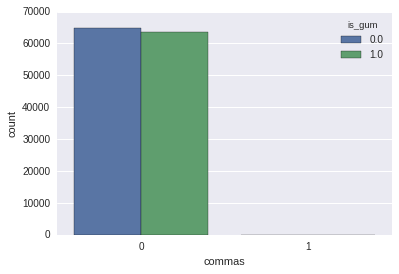

In [629]:
sns.countplot(x='commas', hue='is_gum', data=comments)

### Mean word length

In [150]:
def mean_word_length(comments):
    lengths = []
    for comment in comments:
        comment = comment.lower()
        comment = re.sub('[^а-яё\-]', ' ', comment).split()
        ls = [len(w) for w in comment]
        if len(ls):
            lengths.append(sum(ls) / len(ls))
        else:
            lengths.append(1)
    return lengths

In [526]:
comments_list[35:40]

['Все вопросы к администратору магазина! Незнания порядка не дает права вам нарушать его а жалобу можно отдать как администратору так и директору или есть такая КНИГА ЖАЛОБ',
 'Сука 100 р по везету и Вы в любом конце',
 'Папа новые даст не переживай😀',
 'Это чисто две банды долбоебов как от факела так и от динамо',
 'Сердце Егора ухнуло в пятки.']

In [530]:
mean_length = mean_word_length(comments_list)
mean_length[35:40]

[5.296296296296297, 3.0, 4.8, 4.0, 4.6]

In [531]:
mean_length = np.reshape(mean_length, (-1, 1))

In [534]:
baseline_scores = cross_val_score(lr, mean_length, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.520029569683 0.0124683358375


### Caps WORD

In [151]:
def caps_words(comments, partion=True):
    caps = []
    for comment in comments:
        count = len(re.findall('[А-ЯЁA-Z\-]{4,}', comment))
        total = len(comment.split())
        if partion and total != 0:
            caps.append(count / total * 100)
        else:
            caps.append(1 if count > 0 else 0)
    return caps

In [152]:
caps = caps_words(comments_list, False)

In [143]:
comments_list[:10]

['НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ОТПРАВИТЬ 💪💪💪💪💪',
 'adddresssation не имеет значение где ЮР, ардрес то',
 'adddresssation где СК удобнее там и проводят а поближе подороже! Могу мск то сделать 650р',
 'Сегодня в 23:00 до 5:00 собираемся все НА АРЕНЕ и Валим там пока покрышки не сгорят... В ПРОТЕСТ СКУЧНЫМ И НУДНЫМ МУДАКАМ',
 'adddresssation пошлиб да проявили смелость там😉',
 'adddresssation любое ДТП есть страховой случай! И будет оплачиваться в законном порядке... А как в тебя въехали не ИМЕЕТ ЗНАЧЕНИЯ!',
 'adddresssation что если кого то что то неустраевает пойти и решить проблему, а не писать в типичный что под их окнами газуют...У ВСЕХ ГАЗУЮТ',
 'Норма у всех своя, а правила регулируют закон... А если так то действуй а не ори что у тебя проблема',
 'adddresssation да будет так',
 'Для особо одаренных есть ночные смены😀']

In [144]:
caps[:10]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 0]

In [145]:
pd.Series(caps).value_counts()

0    124626
1      3884
dtype: int64

In [83]:
caps = np.reshape(caps, (-1, 1))

In [587]:
baseline_scores = cross_val_score(lr, caps, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.505563769356 0.0


### English words

In [153]:
def eng_words(comments, partion=True):
    engs = []
    for comment in comments:
        count = len([w for w in re.findall('[a-z\-]{3,}', comment, flags=re.IGNORECASE) if w != 'adddresssation'])
        total = len(comment.split())
        if partion and total != 0:
            engs.append(count / total * 100)
        else:
            engs.append(1 if count > 0 else 0)
    return engs

In [154]:
engs = eng_words(comments_list, False)

In [103]:
pd.Series(engs).value_counts()

0    110549
1      1621
dtype: int64

In [617]:
engs = np.reshape(engs, (-1, 1))

In [619]:
lr = lm.LogisticRegression()

In [623]:
baseline_scores = cross_val_score(lr, engs, y, cv=10)
print(baseline_scores.mean(), baseline_scores.stdt())

0.505563769356 0.0


### All comments features together

In [155]:
def get_comments_features(coms):
    features = pd.DataFrame()
    features['with_emoji'] = with_emoji(coms)
    big_letter, sents_count = sentence_stat(coms)
    features['big_letter'] = big_letter
    features['sents_count'] = sents_count
    features['punct_)'] = punctuation_counts(coms, pattern='\)+')
    features['punct_('] = punctuation_counts(coms, pattern='\)+', partion=False)
    features['punct_...'] = punctuation_counts(coms, pattern='\.\.\.', partion=False)
    features['punct_?'] = punctuation_counts(coms, pattern='\?+')
    features['punct_!'] = punctuation_counts(coms, pattern='\!+')
    features['punct_..'] = punctuation_counts(coms, pattern='[\.]{2,}')
    features['punct_1-9'] = punctuation_counts(coms, pattern='[0-9]{1,}')
    features['punct_"'] = punctuation_counts(coms, pattern='".+"')
    features['eng_words'] = eng_words(coms, True)
    features['mean_word_len'] = mean_word_length(coms)
    features['caps'] = caps_words(coms, True)
    features['em_proportion_rep'] = comments['em_proportion_rep'].values
    features['em_proportion_no_rep'] = comments['em_proportion_no_rep'].values
    features['adj_proportion'] = adj_proportion
    features['abc_proportion'] = comments['abc_proportion'].values
    return features

In [156]:
comment_features = get_comments_features(comments_list)

In [157]:
comment_features.describe()

,with_emoji,big_letter,sents_count,punct_),punct_(,punct_...,punct_?,punct_!,punct_..,punct_1-9,"punct_""",eng_words,mean_word_len,caps,em_proportion_rep,em_proportion_no_rep,adj_proportion,abc_proportion
count,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000
mean,0.086546,0.669578,1.784646,0.896777,0.249744,0.143824,0.434742,0.407384,0.848842,0.513379,1.419241,0.242001,4.726950,0.421457,0.002817,0.002049,0.095742,0.837275
std,0.281170,0.470367,1.177020,2.280447,0.432867,0.350913,1.205701,1.578833,2.350799,2.125769,7.959314,2.851777,0.958116,3.692291,0.013103,0.008321,0.096758,0.112517
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.400000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.125000,0.000000,0.000000,0.000000,0.000000,0.754717
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.666667,0.000000,0.000000,0.000000,0.086957,0.857143
75%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.266667,0.000000,0.000000,0.000000,0.153846,0.933333
max,1.000000,1.000000,21.000000,53.061224,1.000000,1.000000,53.448276,38.775510,44.660194,45.833333,100.000000,110.000000,20.571429,120.000000,0.250000,0.250000,1.000000,1.000000


## word2vec

In [157]:
model_web = word2vec.Word2Vec.load_word2vec_format('../RussianHorrorStories/models_bin/web.model.bin', binary=True)

In [158]:
def get_vector_from_words(words, model, num_features):
    features = np.zeros((num_features,), dtype=np.float32)
    n = 0
    index2word = set(model.index2word)
    
    for word in words:
        if word in index2word:
            features += model[word]
            n += 1
    return features / n

In [159]:
def get_texts_vectors(texts, model, num_features):
    texts_vectors = np.zeros((len(texts), num_features), dtype=np.float32)
    
    i = 0
    for text in texts:
        texts_vectors[i] = get_vector_from_words(text.split(), model, num_features)
        i += 1
    return texts_vectors

In [160]:
for i in range(len(model_web.index2word)):
    model_web.index2word[i] = re.split('_', model_web.index2word[i])[0]
model_web.vocab = {re.split('_', x[0])[0]: x[1] for x in list(model_web.vocab.items())}

In [170]:
clear_coms[30:35]

['adddresssation дак сельпа сколько город едить область загибаться работа нет поэтому там продавать тут покупать',
 'adddresssation ипотека разница добивать основное чтобы новостройка купить жить правило чтобы что купить надо что продать нал брать сразу северянин сталкиваться только такой расклад',
 'adddresssation конечно кабала бич молодая семья',
 'adddresssation есть кто жить дак сдавать они',
 'adddresssation убрать товарный правда убирать уже год сейчас станция уже ночь перестать работать иногда работать день машинист туда халтура без график ездить поэтому она уже изживать себя насчёт путин тоже ждать когда сдохнуть']

In [169]:
%%time
vects = get_texts_vectors(clear_coms, model_web, 500)

CPU times: user 1h 17min 11s, sys: 2.19 s, total: 1h 17min 13s
Wall time: 2h 15min 12s


In [181]:
(np.isnan(vects).sum(axis=1)).sum()

0

In [180]:
vects = np.nan_to_num(vects)

In [171]:
for vec in vects[30:35]:
    print(model_web.similar_by_vector(vec, 5))

[('поэтому', 0.5718047618865967), ('информайция', 0.5706641674041748), ('складывай', 0.5617139339447021), ('покупать', 0.559929609298706), ('сколько', 0.5405701398849487)]
[('информайция', 0.5880330204963684), ('складывай', 0.576613187789917), ('купить', 0.5577439069747925), ('абрамсаидычиванов', 0.5528272390365601), ('приземл', 0.5520462393760681)]
[('кабала', 0.6205751895904541), ('семья', 0.6001030206680298), ('молодая', 0.5578511953353882), ('бич', 0.54442298412323), ('бедняк', 0.42524629831314087)]
[('жить', 0.6571881771087646), ('дак', 0.6414352655410767), ('сдавать', 0.6106940507888794), ('тож', 0.507592499256134), ('йти', 0.49388185143470764)]
[('информайция', 0.6323297023773193), ('работать', 0.59303218126297), ('приземл', 0.59165358543396), ('складывай', 0.5661138892173767), ('абрамсаидычиванов', 0.5565855503082275)]


In [114]:
index_to_del = comments[(np.isnan(vects).sum(axis=1) != 0)].index

In [115]:
index_to_del.shape

(1449,)

In [117]:
comments.drop(index_to_del, inplace=True)
comments_list = comz pments_list[np.isnan(vects).sum(axis=1) == 0]
vects = vects[np.isnan(vects).sum(axis=1) == 0]

In [124]:
y = comments.is_gum.values

In [125]:
lr = lm.LogisticRegression()

In [126]:
%%time
baseline_scores = cross_val_score(lr, vects, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.525522550247 0.00909039521214
CPU times: user 49.6 s, sys: 4.49 s, total: 54.1 s
Wall time: 1min 18s


## LDA

## Filtering dictionary

In [129]:
import copy

In [258]:
splited_coms = [com.split() for com in clear_coms]
dictionary = corpora.Dictionary(splited_coms)
corpus = [dictionary.doc2bow(com) for com in splited_coms]
print(dictionary)

Dictionary(60595 unique tokens: ['but', 'антенщик-', 'спаситель', 'миниатуюр', 'жалобщик']...)


In [259]:
dictionary_filtered = copy.deepcopy(dictionary)
dictionary_filtered.filter_extremes(no_below=10, no_above=0.5)

In [260]:
with open('names_from_sent.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]
names_ids = []
for name in names:
    try:
        names_ids.append(dictionary_filtered.token2id[name])
    except:
        pass
dictionary_filtered.filter_tokens(bad_ids=names_ids)

In [261]:
print(dictionary_filtered)

Dictionary(8633 unique tokens: ['быт', 'скопировать', 'пфффф', 'режим', 'старый']...)


In [262]:
dict_count_before= len(dictionary)
corpus_size_before = sum([word[1] for document in corpus for word in document])
corpus = [dictionary_filtered.doc2bow(text) for text in splited_coms]
dict_count_after = len(dictionary_filtered)
corpus_size_after = sum([word[1] for document in corpus for word in document])

In [263]:
print('Dictionary size\nBefore: {}; after: {}\nCorpus size\nBefore: {}; after: {}'.format(
      dict_count_before, dict_count_after, corpus_size_before, corpus_size_after))

Dictionary size
Before: 60595; after: 8633
Corpus size
Before: 1151920; after: 971131


In [264]:
dictionary_filtered.save('models_bin/dictionary_filtered')

### Model

If already trained before

In [ ]:
%%time
dictionary_filtered = corpora.Dictionary.load('models_bin/dictionary_filtered')
splited_texts = [text.split() for text in stemmed_posts_texts]
corpus = [dictionary_filtered.doc2bow(text) for text in splited_texts]

In [274]:
%%time
ldamodel = models.LdaModel(corpus, id2word=dictionary_filtered, num_topics=30, passes=50,
                           alpha='auto', eta='auto')

CPU times: user 30min 7s, sys: 1.53 s, total: 30min 9s
Wall time: 30min 7s


In [275]:
ldamodel.save('models_bin/lda')

In [ ]:
ldamodel = models.LdaModel.load('models_bin/lda')

In [278]:
for i, topic in ldamodel.show_topics(num_topics=30, num_words=5, formatted=False):
    print("Topic " + str(i) + ': ')
    for word, p in topic:
        print(word, p)

Topic 0: 
даже 0.110408936734
очень 0.106153695361
ребёнок 0.0653334630849
много 0.0587955610491
пара 0.0307449519816
Topic 1: 
хороший 0.139851781379
самый 0.0805245816061
наш 0.0700121438782
дело 0.0608843326843
всегда 0.0480964880692
Topic 2: 
что 0.0966779047198
это 0.0817553344666
быть 0.0672078968897
весь 0.0666834692074
как 0.0472868536596
Topic 3: 
твой 0.0762068680035
сделать 0.071278910899
хорошо 0.0629373529718
народ 0.0444079540082
куда 0.0432168446993
Topic 4: 
идти 0.0698764588424
нормальный 0.0497431838335
дорога 0.0474298490072
кстати 0.0382063777777
именно 0.0358608662124
Topic 5: 
блин 0.0655463678783
парень 0.0426374069839
кажется 0.0381042254424
номер 0.0370874652349
помочь 0.0370788164579
Topic 6: 
смотреть 0.0675120761159
два 0.0580830158353
работать 0.0524956534856
хотя 0.05132913354
посмотреть 0.0393366114219
Topic 7: 
вообще 0.157818102985
хотеть 0.144657530718
сказать 0.133594665286
играть 0.023192100525
фильм 0.0204413822616
Topic 8: 
друг 0.0860163929578
пра

In [287]:
comments_list[10000]

'adddresssation 😂😂😂😂промазал тут речь о бензине😂😂😂'

In [294]:
ldamodel.get_document_topics(list(corpus)[10], minimum_probability=0.05)

[(2, 0.24596399685590126),
 (10, 0.087319542810898765),
 (22, 0.051959510081673307)]

In [286]:
topic = ldamodel.show_topic(22, 10)
for word, p in topic:
    print(word, p)

один 0.0819362263706
нет 0.0775521652213
мой 0.0625288679389
который 0.049538139932
ваш 0.0244850380353
под 0.0217745365791
дать 0.0208372124593
более 0.0161446560091
бог 0.0119206661115
девочка 0.00858602857106


In [273]:
perplexity = ldamodel.log_perplexity(list(corpus))
print(2**(-perplexity))

282.892353183


In [277]:
perplexity = ldamodel.log_perplexity(list(corpus))
print(2**(-perplexity))

172.318180434


## Getting LDA Feature matrix

In [ ]:
splited_train_texts = [text.split() for text in x_train]
corpus_train_dataset = [dictionary_filtered.doc2bow(text) for text in splited_train_texts]

In [167]:
def get_corpus_matrix(model, corpus):
    matrix = np.zeros((len(corpus), model.num_topics))
    for i in range(len(corpus)):
        doc_topics = model.get_document_topics(list(corpus)[i], minimum_probability=0.05)
        for topic_id, prob in doc_topics:
            matrix[i, topic_id] = prob
    return matrix

In [169]:
%%time
X_lda = get_corpus_matrix(ldamodel, corpus)

CPU times: user 9min 38s, sys: 300 ms, total: 9min 38s
Wall time: 9min 38s


In [170]:
X_lda.shape

(111920, 50)

In [230]:
comments.shape

(111920, 10)

In [125]:
lr = lm.LogisticRegression()

In [231]:
%%time
baseline_scores = cross_val_score(lr, X_lda, comments.is_gum, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.509935668335 0.00745228690032
CPU times: user 1.7 s, sys: 1.85 s, total: 3.54 s
Wall time: 2.17 s


## Final model

In [120]:
word_char_features.shape, comment_features.shape # meta_features.shape

((111920, 2000), (111920, 18))

In [121]:
X = np.hstack((word_char_features.toarray(), comment_features.values))

In [122]:
X.shape

(111920, 2018)

In [90]:
y = comments.is_gum.values

In [112]:
lr = lm.LogisticRegression()

In [165]:
lr = naive_bayes.MultinomialNB()

In [124]:
lr = ensemble.RandomForestClassifier(20, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [189]:
lr = ensemble.GradientBoostingClassifier()

In [190]:
np.random.seed(0)

In [97]:
baseline_scores = cross_val_score(lr, X, y, cv=3)
print(baseline_scores.mean(), baseline_scores.std())

0.521181838852 0.0138376103516


## Testing on human

In [106]:
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit

In [107]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [138]:
s = StratifiedShuffleSplit(y, n_iter=1, test_size=20, random_state=0)

In [139]:
index_test = []

In [140]:
for train, test in s:
    index_test = test
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

In [141]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [152]:
prediction = lr.predict_proba(X_test)[:, 1]

In [143]:
accuracy_score(y_test, prediction)

0.34999999999999998

In [144]:
ans = []
for comment in comments_list[index_test]:
    a = input(comment)
    ans.append(int(a))

Так у них же пллан какой то есть, типа стоять на всех главных перекрестках0
Только ковры на стены вешать, иначе слышно все1
adddresssation о, спасибо чувак, и тебе зачёт великий! Хоть кто-то знает, насколько клёвая штука - осциллограф!0
adddresssation Даже сапер имеет право на ошибку...Так вот...Я не он1
adddresssation я не говорила что нет обработки. фотошоп исправляет недостатки, а здесь просто улучшено качество самой фотографии.1
adddresssation мне не нужен допинг чтобы источать радость и хорошее настроение ☺1
adddresssation ну это да. было бы желание.0
adddresssation Вы имели ввиду "никто не шутит"0
adddresssation Самвел армянское имя и к Махачкалинской области РФ(Дагестану) никакого отношения не имеет1
В 6 движуха уже во всю0
adddresssation Замена заявленного кондидата в олимпийских игр происходит как минимум за 3 дня и то по травме))1
Посмотреть что ли в окно0
adddresssation согласна, некоторые дети бросают своих стариков 😔1
Пересматриваю все части, чтобы пойти на 7ю подготовленн

In [145]:
sum(ans)

12

In [146]:
len(ans)

20

In [147]:
accuracy_score(y_test, ans)

0.69999999999999996

In [150]:
y_test = [int(y) for y in y_test]
prediction = [int(p) for p in prediction]

In [153]:
list(zip(comments_list[index_test], y_test, prediction, ans))

[('Так у них же пллан какой то есть, типа стоять на всех главных перекрестках',
  0,
  0.51186352495835707,
  0),
 ('Только ковры на стены вешать, иначе слышно все', 0, 0.51120625719204627, 1),
 ('adddresssation о, спасибо чувак, и тебе зачёт великий! Хоть кто-то знает, насколько клёвая штука - осциллограф!',
  0,
  0.37807061591042296,
  0),
 ('adddresssation Даже сапер имеет право на ошибку...Так вот...Я не он',
  1,
  0.54625583923717969,
  1),
 ('adddresssation я не говорила что нет обработки. фотошоп исправляет недостатки, а здесь просто улучшено качество самой фотографии.',
  1,
  0.42449077280158115,
  1),
 ('adddresssation мне не нужен допинг чтобы источать радость и хорошее настроение ☺',
  1,
  0.45122448038554991,
  1),
 ('adddresssation ну это да. было бы желание.', 1, 0.61851027790870372, 0),
 ('adddresssation Вы имели ввиду "никто не шутит"', 0, 0.52869545175277877, 0),
 ('adddresssation Самвел армянское имя и к Махачкалинской области РФ(Дагестану) никакого отношения не и